In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
folder = 'drive/MyDrive/Code/GitHub/CellularAutomata'
import sys
sys.path.insert(1, folder)
import ca_model
import count_pixels_dataset as cpd
import visualisation as vis_ca
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1584023301570521923
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2515923480175955333
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
# import importlib
# importlib.reload(ca_model)
# importlib.reload(vis_ca)

In [4]:
# Type of Run
JustTestingCodeQ = False # If True run everything faster, for Debugging
LoadPreviousModelQ = True # if True we load the model, either for further training or just testing
i_step_load = 120000
RunTrainingQ = True # If True we run the neural network training
RunTestMoviesQ = True # if True, in the end we test an increasing size of inputs
MutateTestingQ = True # if True, during testing we mutate the image
RunTestIncreaseQ = True # if True, in the end we test an increasing size of inputs
SEED_TRAINING = 1
SEED_MOVIES = 1

In [5]:
# Model Options
model_complexity = 'middle' # 'simplest' 'middle' 'complex'
AddNoiseQ = True # if True then the normal update of the CA has noise added
InitializeRandomQ = True # if True, the initial state of the CA is random
MutateTrainingQ = True # if True, during training we mutate the image to anothe random one
no_channels = '4TimesClasses' # 'SameClasses' '5PlusClasses' '4TimesClasses'
TR_EVOLVE = 50 # Number of time steps to let CA evolve for each input during training
TST_EVOLVE = 50 # Number of time steps to let CA evolve for each input during testing
BATCH_SIZE = 64 # number of images per batch
LR = 1e-3 # initial learning rate
UseLRScheduleQ = True # if True use Adam with a learning rate schedule

In [6]:
# Task and Dataset
NO_CLASSES = 8 # Number of classes that the CA must distinguish ## 2 3 5 8
limits_classes = [2, 5, 9, 14, 20, 27, 35] # boundaries of the classes. len of this should be NO_CLASSES-1 ## [2]  [2, 8] [2, 5, 8, 12] [1, 2, 3, 5, 7, 10, 13] [2, 5, 9, 14, 20, 27, 35]
MAXPIXELS = 44 # Maximum allowed contiguous pixels for the images ## 10 15 44
RebuildDatasetQ = True # if True we rebuild the dataset
SIZE_DS = 100000 #the number of images on the dataset
H, W = 10, 10 # Height and Width of the images
BOUNDARY_P = 0.4 # the proportion of the dataset devoted to the boundaries of the dataset
SEED_DATASET = 1

In [7]:
if JustTestingCodeQ:
    TR_NO_ITERATIONS = 500 # number of iterations for the training loop
    EXPORT_EVERY = 100 # number of iterations between each model export
    VISUALISE_EVERY = 50 # number of iteration between each model visualisation
    i_step_verify = [500] # [250, 500]
else:
    TR_NO_ITERATIONS = 500000 # number of iterations for the training loop
    EXPORT_EVERY = 2000 # number of iterations between each model export
    VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    i_step_verify = [240000, 500000] # [240000, 500000]

    TR_NO_ITERATIONS = 5000 # number of iterations for the training loop
    EXPORT_EVERY = 1000 # number of iterations between each model export
    VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    i_step_verify = [0, 5000] # [240000, 500000]

    TR_NO_ITERATIONS = 20000 # number of iterations for the training loop
    EXPORT_EVERY = 1000 # number of iterations between each model export
    VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    i_step_verify = [0, 20000] # [240000, 500000]

    TR_NO_ITERATIONS = 50000 # number of iterations for the training loop
    EXPORT_EVERY = 2000 # number of iterations between each model export
    VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    i_step_verify = [50000, 100000] # [240000, 500000]

    TR_NO_ITERATIONS = 200000 # number of iterations for the training loop
    EXPORT_EVERY = 2000 # number of iterations between each model export
    VISUALISE_EVERY = 500 # number of iteration between each model visualisation
    i_step_verify = [100000, 200000] # [240000, 500000]
    
    #
if LoadPreviousModelQ and not RunTrainingQ:
    i_step_verify = [i_step_load]

cb_str = str(limits_classes).replace('[', '').replace(']', '').replace(', ', '_')
ds_str = 'CountDigits{}_H{}_W{}_ClassB{}_MaxPixels{}_BoundP{}_Seed{}'.format(SIZE_DS, H, W, cb_str, MAXPIXELS, int(BOUNDARY_P*100), SEED_DATASET)
id_str = 'CA_{}_ModlComplx{}_AddNoise{}_InitRnd{}_MutTrain{}_Channels{}'.format(ds_str, model_complexity, AddNoiseQ, InitializeRandomQ, MutateTrainingQ, no_channels) # the prefix to all file names which will be use for saving and loading the model
print(id_str)

limits_c_p = [0] + limits_classes + [MAXPIXELS]
if NO_CLASSES == 2:
    color_lookup = tf.constant([
                        [255, 0, 0], #These are the colors for the different classes
                        [0, 255, 0],
                        [0, 0, 0], # This is the default for digits.
                        [255, 255, 255] # This is the background.
                        ])
elif NO_CLASSES == 3:
    color_lookup = tf.constant([
                        [255, 0, 0], #These are the colors for the different classes
                        [0, 255, 0],
                        [0, 0, 255],
                        [0, 0, 0], # This is the default for digits.
                        [255, 255, 255] # This is the background.
                        ])
elif NO_CLASSES == 5:
    color_lookup = tf.constant([
                        [255, 0, 0], #These are the colors for the different classes
                        [0, 255, 0],
                        [0, 0, 255],
                        [255, 255, 0],
                        [0, 255, 255],
                        [0, 0, 0], # This is the default for digits.
                        [255, 255, 255] # This is the background.
                        ])
elif NO_CLASSES == 8:
    color_lookup = tf.constant([
                        [85, 85, 85], #These are the colors for the different classes
                        [255, 0, 0], 
                        [0, 255, 0],
                        [0, 0, 255],
                        [255, 255, 0],
                        [0, 255, 255],
                        [255, 0, 255],
                        [170, 170, 170],
                        [0, 0, 0], # This is the default for digits.
                        [255, 255, 255] # This is the background.
                        ])

if no_channels == 'SameClasses':
    NO_CHANNELS = NO_CLASSES # number of hidden states of the CA, must be at least NO_CLASSES because there are two outputs
elif no_channels == '4TimesClasses':
    NO_CHANNELS = 4 * NO_CLASSES # number of hidden states of the CA, must be at least NO_CLASSES because there are two outputs
elif no_channels == '5PlusClasses':
    NO_CHANNELS = 5 + NO_CLASSES # number of hidden states of the CA, must be at least NO_CLASSES because there are two outputs

if UseLRScheduleQ:
    first_point = int(TR_NO_ITERATIONS*0.3333)
    second_point = int(TR_NO_ITERATIONS*0.6667)
    if LoadPreviousModelQ and RunTrainingQ:
        if i_step_load > second_point:
            trainer = tf.keras.optimizers.Adam(learning_rate=LR*0.01) # use ADAM optimizer
        elif i_step_load > first_point:
            remaining_steps = TR_NO_ITERATIONS - i_step_load
            lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2 * (second_point - i_step_load)], [LR*0.1, LR*0.01]) # we need to multiply by two because in each training step we perform 2 gradient descents
            trainer = tf.keras.optimizers.Adam(lr_sched) # use ADAM optimizer with learning rate schedule
        else:
            lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2 * (first_point - i_step_load), 2 * (second_point - i_step_load)], [LR, LR*0.1, LR*0.01]) # we need to multiply by two because in each training step we perform 2 gradient descents
    else:
        lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2*first_point, 2*second_point], [LR, LR*0.1, LR*0.01]) # we need to multiply by two because in each training step we perform 2 gradient descents
    trainer = tf.keras.optimizers.Adam(lr_sched) # use ADAM optimizer with learning rate schedule
else:
    trainer = tf.keras.optimizers.Adam(learning_rate=LR) # use ADAM optimizer

loss_log = np.zeros(TR_NO_ITERATIONS) # for plotting of loss function across time
loss_log_classes = np.zeros((TR_NO_ITERATIONS, NO_CLASSES)) # for plotting of loss function across time

CA_CountDigits100000_H10_W10_ClassB2_5_9_14_20_27_35_MaxPixels44_BoundP40_Seed1_ModlComplxmiddle_AddNoiseTrue_InitRndTrue_MutTrainTrue_Channels4TimesClasses


1


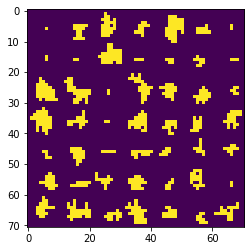

In [8]:
# Prepare the dataset
BuildDS = False
if RebuildDatasetQ:
    BuildDS = True
else:
    try:
        res = np.load(folder + '/dataset/{}.npz'.format(ds_str))
        x_train, x_test, y_train, y_test = res['x_train'], res['x_test'], res['y_train'], res['y_test']
    except:
        BuildDS = True
if BuildDS:
    x_train, x_test, y_train, y_test = cpd.build_dataset(SIZE_DS, H, W, limits_classes, max_pixels=MAXPIXELS, boundary_p=BOUNDARY_P)
    np.savez(folder + '/dataset/{}.npz'.format(ds_str), x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

    cols=7
    rows=7
    fig, ax = plt.subplots()
    DISP = np.zeros((1, cols * W + 1))
    for i in range(rows):
        disp = np.zeros((H, 1))
        for j in range(cols):
            disp = np.hstack((disp, x_train[np.random.randint(int(SIZE_DS/10)), :, :]))
        DISP = np.vstack((DISP, disp))
    ax.imshow(DISP)

    print(np.prod((np.sum(x_train, axis=(1, 2)) == y_train) * 1))

y_train_pic = cpd.to_classes_dim_label(x_train, y_train, limits_classes)
y_label_train = np.zeros(y_train.shape[0])
for i in range(y_train.shape[0]):
    y_label_train[i] = cpd.class_indice_f(y_train[i], limits_classes)

In [9]:
if LoadPreviousModelQ:
    ca, loss_log, loss_log_classes = ca_model.get_model(folder, id_str, i_step_load, NO_CHANNELS, NO_CLASSES, H, W, AddNoiseQ, model_complexity)
    ITER = i_step_load + 1
else:
    ca = ca_model.CAModel(NO_CHANNELS, NO_CLASSES, H, W, add_noise=AddNoiseQ, model_complexity=model_complexity)
    ITER = 0

In [10]:
ca.update_state.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 10, 10, 40)           11920     
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 10, 10, 32)           1312      
Total params: 13,232
Trainable params: 13,232
Non-trainable params: 0
_________________________________________________________________


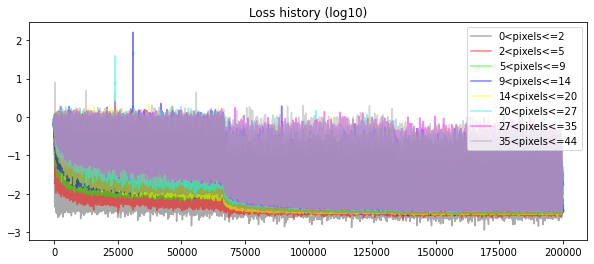

 step: 200000, log10(loss): -1.4867010116577148

In [11]:
# Training happens here
np.random.seed(SEED_TRAINING)
if RunTrainingQ:
    # Training Loop
    for i in range(ITER, TR_NO_ITERATIONS):
        b_idx = np.random.randint(x_train.shape[0], size=BATCH_SIZE)
        if InitializeRandomQ:
            x0 = ca.initialize_random(x_train[b_idx])
        else:
            x0 = ca.initialize(x_train[b_idx])
        y0 = y_train_pic[b_idx]
        y0_label = y_label_train[b_idx]
        y0_label = tf.convert_to_tensor(y0_label)        

        x, loss, c_l = ca_model.train_step(trainer, ca, x0, y0, y0_label, TR_EVOLVE, NO_CLASSES, MutateTrainingQ=MutateTrainingQ)

        loss_log[i] = loss.numpy()
        loss_log_classes[i, :] = [k.numpy() for k in c_l]

        if i % VISUALISE_EVERY == 0:
            clear_output()
            vis_ca.plot_loss(loss_log[:i], loss_log_classes[:i, :], folder, id_str, limits_c_p, color_lookup, True)
        if i % EXPORT_EVERY == 0:
            ca_model.export_model(folder, id_str, ca, i, loss_log, loss_log_classes)

        if NO_CLASSES > 5:
            print('\r step: {}, log10(loss): {}'.format(i + 1, np.log10(loss)), end='')
        else:
            print('\r step: {}, log10(loss): {}, log10(loss)[classes]: {}'.format(i + 1, np.log10(loss), np.log10(c_l)), end='')
    ca_model.export_model(folder, id_str, ca, TR_NO_ITERATIONS, loss_log, loss_log_classes)

In [12]:
if RunTestMoviesQ:
    eval_bs = 5 ** 2 # number of samples to show in the movie
    for i_step_v in i_step_verify:
        ca, loss_log, loss_log_classes = ca_model.get_model(folder, id_str, i_step_v, NO_CHANNELS, NO_CLASSES, H, W, AddNoiseQ, model_complexity)

        np.random.seed(SEED_MOVIES)

        new_idx = np.random.randint(0, x_test.shape[0] - 1, size=eval_bs)
        if InitializeRandomQ:
            x0 = ca.initialize_random(x_test[new_idx])
        else:
            x0 = ca.initialize(x_test[new_idx])

        vis_ca.make_run_videos(folder, id_str, i_step_v, TST_EVOLVE, MutateTestingQ, x0, ca, color_lookup)

100%|██████████| 51/51 [00:00<00:00, 118.90it/s]


In [13]:
if RunTestIncreaseQ:
    eval_bs = 5 ** 2 # number of samples to show in the movie
    max_size = MAXPIXELS

    images = np.zeros((max_size, eval_bs, H, W), dtype=np.float32)
    for i_img in range(eval_bs):
        images[0, i_img, int(H / 2), int(W / 2)] = 1
    for j in range(1, max_size):
        for i_img in range(eval_bs):
            images[j, i_img, :, :] = vis_ca.add_pixel(images[j - 1, i_img, :, :])
    images = tf.constant(images)
    
    for i_step_v in i_step_verify:
        ca, loss_log, loss_log_classes = ca_model.get_model(folder, id_str, i_step_v, NO_CHANNELS, NO_CLASSES, H, W, AddNoiseQ, model_complexity)
        vis_ca.make_videos_increase(folder, id_str, i_step_v, TST_EVOLVE, ca, color_lookup, images, InitializeRandomQ)

100%|██████████| 50/50 [00:00<00:00, 287.97it/s]


100%|██████████| 50/50 [00:00<00:00, 335.55it/s]
